### Import Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import pygimli as pg
import pygimli.meshtools as mt
import pygimli.physics.ert as ert

import os, os.path
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import multivariate_normal
import scipy as sp
import scipy.stats as st
from scipy import interpolate

import sys
sys.path.append("..")
from ERTsim import PHert

import pickle as pkl


import pandas as pd

### Define Functions for Later

In [2]:
def sample_data(N,dmean,dstd):
    D_N = np.zeros((N,dmean.shape[0]))
    for i in range(dmean.shape[0]):
        D_N[:,i] = np.random.normal(dmean[i], dstd[i], N)
    return D_N
        
def train_reg(dtrain, vtrain):
    return RandomForestRegressor().fit(dtrain, vtrain)

def sample_posterior(reg, dtest, vtest_true, D_N, W):
    vtest_pred = reg.predict(dtest)
    vmeas_pred = reg.predict(D_N)

    postsamples = np.zeros(D_N.shape[0])
    for i in range(D_N.shape[0]):
        INDS = np.where(np.logical_and(vtest_pred>=vmeas_pred[i]-W, vtest_pred<=vmeas_pred[i]+W))
        csamples = vtest_true[INDS]
        try:
            sample_ind = np.random.choice(csamples.shape[0], 1)
            postsamples[i] = csamples[sample_ind]
        except:
            pass
        
        
    return postsamples

def compute_post_quantile(postsamples, truth):
    num_smaller = sum(postsamples <= truth)
    quantile = num_smaller / postsamples.shape[0]
    return quantile
    

# Import Measured Data (For Plotting Purposes Only)

In [3]:
sfile = '../data/PH-2018-srv.txt'
efile = '../data/PH-2018-eloc.txt'
srv = pd.read_csv(sfile,sep='\t',header=None)
elec = pd.read_csv(efile,sep='\t',header=None)

M = (elec.values[srv.values[:,2][:].astype(int)-1,1]+elec.values[srv.values[:,4][:].astype(int)-1,1])/2
C = (elec.values[srv.values[:,1][:].astype(int)-1,3]+elec.values[srv.values[:,3][:].astype(int)-1,3])/2 - (elec.values[srv.values[:,4][:].astype(int)-1,1]-elec.values[srv.values[:,2][:].astype(int)-1,1])/2



# Import Monte Carlo Data (Train/Test and Validation Sets)

In [4]:
valfolder = '../data/val/' #Validation set (x1000)
MCfolder = '../data/MC3/' #Train/test set (x2000)
rows = 11 #Number of header rows

### Train/Test Set

In [5]:
pfile = MCfolder + 'params.dat'

files = [name for name in os.listdir(MCfolder) if (os.path.isfile(MCfolder+name) and (name != "params.dat"))]
Nreal = len(files)

In [6]:
D = np.zeros((Nreal,15371))
inds = np.zeros(Nreal,dtype=int)
i = 0
for f in files:
    data = ert.ERTManager(MCfolder+f).data
    R = np.array([data('r')[i] for i in range(data('r').size())])
    D[i,:] = R
    f2 = f.split('_')[1]
    inds[i] = np.int(f2.split('.')[0])
    i = i+1


In [7]:
fullinput = pd.read_csv(pfile,skiprows=rows)
inputs = fullinput.values[inds,:]
fullinput

,dip,H,xpos,rho_fault,rho_back
0,101.833891,115.800812,412.011373,29.642176,49.316446
1,125.126511,174.696599,484.424341,27.897438,229.946475
2,109.386873,53.786238,456.523421,42.869513,72.535312
3,101.283646,126.145778,460.279214,26.864429,58.730871
4,84.311672,56.621057,432.695884,25.424708,68.864551
...,...,...,...,...,...
1995,135.779417,144.507231,406.534273,24.860789,84.199023
1996,125.967736,96.671548,375.001311,31.356123,81.066461
1997,92.215093,145.760068,370.331503,30.884901,85.394349
1998,115.140965,47.364446,405.448911,26.081312,205.104687


### Validation Set

In [8]:
pfile_val = valfolder + 'params.dat'

files_val = [name for name in os.listdir(valfolder) if (os.path.isfile(valfolder+name) and (name != "params.dat"))]
Nreal_val = len(files_val)

In [9]:
D_val = np.zeros((Nreal_val,15371))
inds_val = np.zeros(Nreal_val,dtype=int)
i = 0
for f in files_val:
    data = ert.ERTManager(valfolder+f).data
    R = np.array([data('r')[i] for i in range(data('r').size())])
    D_val[i,:] = R
    f2 = f.split('_')[1]
    inds_val[i] = np.int(f2.split('.')[0])
    i = i+1

In [10]:
fullinput = pd.read_csv(pfile_val,skiprows=rows)
inputs_val = fullinput.values[inds_val,:]
fullinput

,dip,H,xpos,rho_fault,rho_back
0,126.808025,107.841722,402.521031,36.327226,71.961796
1,65.457968,110.617706,377.493612,49.695783,187.624437
2,143.942363,141.476614,362.881855,27.804356,128.061239
3,126.788513,123.715185,436.546621,23.404715,61.428410
4,54.321523,159.553891,386.754161,31.298454,112.467821
...,...,...,...,...,...
1045,61.877444,126.153869,406.650088,26.407154,55.586791
1046,147.893414,175.452929,444.453673,25.889299,101.001632
1047,36.454520,155.066434,417.028753,25.520141,70.160372
1048,41.526414,124.763819,357.029997,35.337055,201.517038


# Add Noise to Monte Carlo Data (Train/Test Sets Only, for Now)

In [11]:
itrain = np.int(np.round(.5 * D.shape[0]))

DNew = np.zeros(D.shape)
for i in range(D.shape[0]):
    DNew[i,:] = sample_data(1,D[i,:],srv.values[:,6])
    
dmean = np.mean(DNew[:itrain,:],axis=0)
dstd = np.std(DNew[:itrain,:],axis=0)
DNew = (DNew-dmean)/dstd


# Train Random Forest Regression Inverse Models

In [12]:
mfile = 'models_NormNoise.pkl'
try:
    models = pkl.load(open( mfile, "rb" ))
except:    
    models = [None]*5
    for i in range(5):
        print('Training '+str(i+1)+' of 5')
        models[i] = train_reg(DNew[:itrain,:],inputs[:itrain,i])

    pkl.dump(models,open(mfile, "wb" ))

# For Each Realization in the Validation Set, Calculate the alpha-quantile

In [13]:
N = 10000
Ws = (2.5, 5, 5, 5, 10)

ntruths = D_val.shape[0]
# ntruths = 50
try:
    quantiles = pkl.load(open('quantiles.pkl',"rb"))
except:
    quantiles = np.ones((ntruths,5))*np.nan
    for i in range(ntruths):
        print('Sampling '+str(i+1)+' of '+str(ntruths))
        D_mean_true = D_val[i,:]
        D_sigma_true = srv.values[:,6]
#         D_N = sample_data(N, D_val[i,:],srv.values[:,6])
        D_N = (sample_data(N, D_mean_true, D_sigma_true) - dmean)/dstd

        for j in range(5):
            postsamples = sample_posterior(models[j], DNew[itrain+1:,:], inputs[itrain+1:,j], D_N, Ws[j])
            quantiles[i,j] = compute_post_quantile(postsamples, inputs_val[i,j])

    pkl.dump(quantiles,open('quantiles.pkl', "wb"))

Sampling 1 of 1043
Sampling 2 of 1043
Sampling 3 of 1043
Sampling 4 of 1043
Sampling 5 of 1043
Sampling 6 of 1043
Sampling 7 of 1043
Sampling 8 of 1043
Sampling 9 of 1043
Sampling 10 of 1043
Sampling 11 of 1043
Sampling 12 of 1043
Sampling 13 of 1043
Sampling 14 of 1043
Sampling 15 of 1043
Sampling 16 of 1043
Sampling 17 of 1043
Sampling 18 of 1043
Sampling 19 of 1043
Sampling 20 of 1043
Sampling 21 of 1043
Sampling 22 of 1043
Sampling 23 of 1043
Sampling 24 of 1043
Sampling 25 of 1043
Sampling 26 of 1043
Sampling 27 of 1043
Sampling 28 of 1043
Sampling 29 of 1043
Sampling 30 of 1043
Sampling 31 of 1043
Sampling 32 of 1043
Sampling 33 of 1043
Sampling 34 of 1043
Sampling 35 of 1043
Sampling 36 of 1043
Sampling 37 of 1043
Sampling 38 of 1043
Sampling 39 of 1043
Sampling 40 of 1043
Sampling 41 of 1043
Sampling 42 of 1043
Sampling 43 of 1043
Sampling 44 of 1043
Sampling 45 of 1043
Sampling 46 of 1043
Sampling 47 of 1043
Sampling 48 of 1043
Sampling 49 of 1043
Sampling 50 of 1043
Sampling 

Sampling 397 of 1043
Sampling 398 of 1043
Sampling 399 of 1043
Sampling 400 of 1043
Sampling 401 of 1043
Sampling 402 of 1043
Sampling 403 of 1043
Sampling 404 of 1043
Sampling 405 of 1043
Sampling 406 of 1043
Sampling 407 of 1043
Sampling 408 of 1043
Sampling 409 of 1043
Sampling 410 of 1043
Sampling 411 of 1043
Sampling 412 of 1043
Sampling 413 of 1043
Sampling 414 of 1043
Sampling 415 of 1043
Sampling 416 of 1043
Sampling 417 of 1043
Sampling 418 of 1043
Sampling 419 of 1043
Sampling 420 of 1043
Sampling 421 of 1043
Sampling 422 of 1043
Sampling 423 of 1043
Sampling 424 of 1043
Sampling 425 of 1043
Sampling 426 of 1043
Sampling 427 of 1043
Sampling 428 of 1043
Sampling 429 of 1043
Sampling 430 of 1043
Sampling 431 of 1043
Sampling 432 of 1043
Sampling 433 of 1043
Sampling 434 of 1043
Sampling 435 of 1043
Sampling 436 of 1043
Sampling 437 of 1043
Sampling 438 of 1043
Sampling 439 of 1043
Sampling 440 of 1043
Sampling 441 of 1043
Sampling 442 of 1043
Sampling 443 of 1043
Sampling 444 

Sampling 788 of 1043
Sampling 789 of 1043
Sampling 790 of 1043
Sampling 791 of 1043
Sampling 792 of 1043
Sampling 793 of 1043
Sampling 794 of 1043
Sampling 795 of 1043
Sampling 796 of 1043
Sampling 797 of 1043
Sampling 798 of 1043
Sampling 799 of 1043
Sampling 800 of 1043
Sampling 801 of 1043
Sampling 802 of 1043
Sampling 803 of 1043
Sampling 804 of 1043
Sampling 805 of 1043
Sampling 806 of 1043
Sampling 807 of 1043
Sampling 808 of 1043
Sampling 809 of 1043
Sampling 810 of 1043
Sampling 811 of 1043
Sampling 812 of 1043
Sampling 813 of 1043
Sampling 814 of 1043
Sampling 815 of 1043
Sampling 816 of 1043
Sampling 817 of 1043
Sampling 818 of 1043
Sampling 819 of 1043
Sampling 820 of 1043
Sampling 821 of 1043
Sampling 822 of 1043
Sampling 823 of 1043
Sampling 824 of 1043
Sampling 825 of 1043
Sampling 826 of 1043
Sampling 827 of 1043
Sampling 828 of 1043
Sampling 829 of 1043
Sampling 830 of 1043
Sampling 831 of 1043
Sampling 832 of 1043
Sampling 833 of 1043
Sampling 834 of 1043
Sampling 835 

# Plot alpha-quantile distributions

/home/ammilten/anaconda3/envs/pg/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


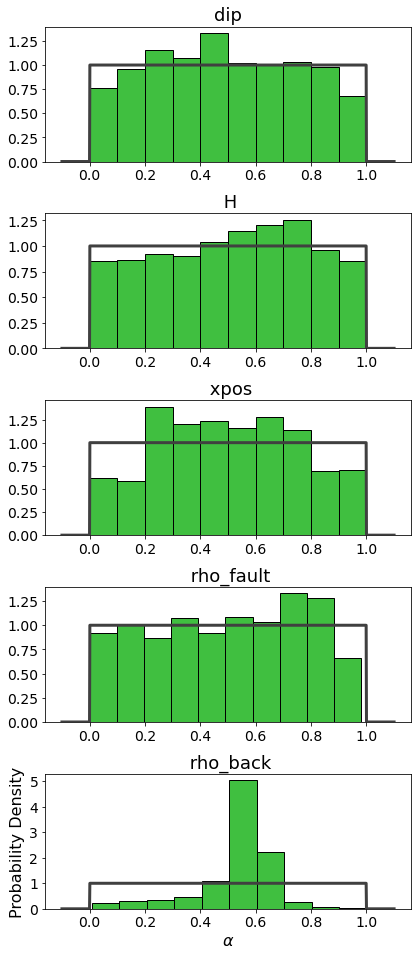

In [14]:
U = st.uniform(loc=0, scale=1)
Ux = np.linspace(-.1,1.1, 1000)
Up = U.pdf(Ux)

fig, axs = plt.subplots(nrows=5, ncols=1, figsize=((6*1.23)*.8,(15*1.05)*.85))
for i in range(5):
    plt.subplot(511+i)
    plt.hist(quantiles[:,i],density=True,facecolor=(.25,.75,.25),edgecolor='k',label='Observed')
    plt.plot(Ux,Up,'-',color=(.25,.25,.25),linewidth=3,label='Theoretical')
    plt.title(fullinput.columns[i],fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    
    
# plt.subplot(511)
# plt.legend()

plt.subplot(515)
plt.ylabel('Probability Density',fontsize=16)
plt.xlabel(r'$\alpha$',fontsize=16)
fig.tight_layout()

/home/ammilten/anaconda3/envs/pg/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/home/ammilten/anaconda3/envs/pg/lib/python3.7/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


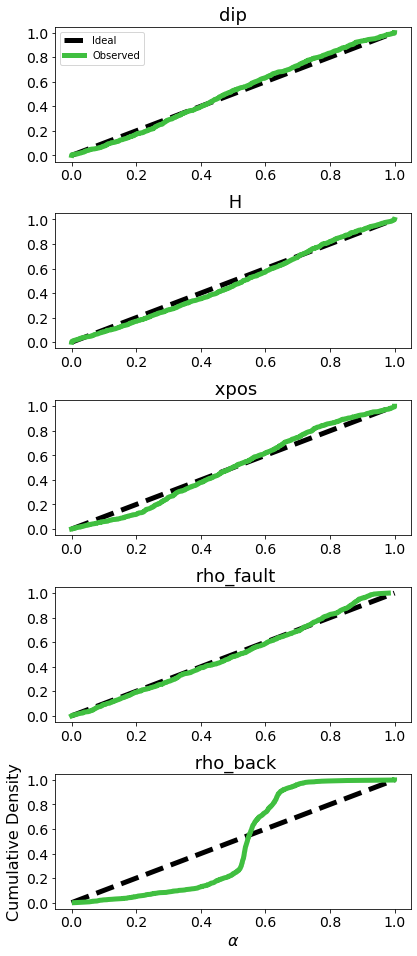

In [15]:
th = np.linspace(0,1,quantiles.shape[0])
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=((6*1.23)*.8,(15*1.05)*.85))
for i in range(5):
    qs = np.sort(quantiles[:,i])
    plt.subplot(511+i)
    plt.plot(th,th,'--k',linewidth=5,label='Ideal')
    plt.plot(qs,th,color=(.25,.75,.25),linewidth=5,label='Observed')
    plt.title(fullinput.columns[i],fontsize=18)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

    
    
plt.subplot(511)
plt.legend()

plt.subplot(515)
plt.ylabel('Cumulative Density',fontsize=16)
plt.xlabel(r'$\alpha$',fontsize=16)
fig.tight_layout()